<font size = "6">4 Predictive Analysis </font>

Our research so far has been mainly about inspecting and analysing the as-is situation. However, in this section aim to go a step further and create tools for predicting future, hourly demand.
Having an accurate prediciton of the demand can be quite critical, as the company can better prepare for the situation. It can help in schedulig repairs or additional bikes and thus help reduce costs and increase revenue.

To actually take advantage of those benefits, we will fit different prediction models on our prepared data, in order to find the best fitting one.


<font size = "6">4.1 Imports </font>

We start by importing all of our needed tools and libraries. Furthermore, we load our cleaned trips- and weather data and bring them into a dataframe form.

In [442]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
from datetime import timedelta
import seaborn as sns
#import graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [443]:
df_chicago = pd.read_csv('../dataset/chicago_2018_clean.csv')
df_weather = pd.read_csv('../dataset/chicago_weather_2018_clean.csv')

# Disclaimer: When we later on talk about demand, we always mean the hourly demand
# Also the column 'Demand' which will be added later on, is representing the hourly demand

Sorting our data is not a crucial step, but allows us to have an inital overview of the different starting times (vielleicht noch umschreiben dont know)

In [444]:
df_sorted = df_chicago.sort_values(by=['start_time'], ascending = [True])
df_sorted.head(5)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration_per_trip,trip_time_in_hours
3212538,2018-01-01 00:12:00,2018-01-01 00:17:23,69,159,Damen Ave & Pierce Ave,Claremont Ave & Hirsch St,3304,Subscriber,0 days 00:05:23,0.089722
3212539,2018-01-01 00:41:35,2018-01-01 00:47:52,253,325,Winthrop Ave & Lawrence Ave,Clark St & Winnemac Ave (Temp),5367,Subscriber,0 days 00:06:17,0.104722
3212540,2018-01-01 00:44:46,2018-01-01 01:33:10,98,509,LaSalle St & Washington St,Troy St & North Ave,4599,Subscriber,0 days 00:48:24,0.806667
3212541,2018-01-01 00:53:10,2018-01-01 01:05:37,125,364,Rush St & Hubbard St,Larrabee St & Oak St,2302,Subscriber,0 days 00:12:27,0.207500
3212542,2018-01-01 00:53:37,2018-01-01 00:56:40,129,205,Blue Island Ave & 18th St,Paulina St & 18th St,3696,Subscriber,0 days 00:03:03,0.050833


<font size = "6">4.2 Feature Engineering </font>

Here we lay the foundation for our following predictions. We aim to engineer experessive features from our, which will later on contribute to our prediction performance. 

We start with the preparing and merging the cleaned trip- and weather data.

In [445]:
#rename date_time column of df_weather in order to successfully merge system load and weather dataframe later on
df_weather.rename(columns = {'date_time':'start_time'}, inplace = True)
#convert now start_time column to datetime format in order to merge later on
df_weather['start_time'] = pd.to_datetime(df_weather['start_time'])
df_weather.head(5)

,start_time,max_temp,min_temp,precip
0,2018-01-01 00:00:00,-13.9,-13.9,0.0
1,2018-01-01 01:00:00,-15.0,-15.0,0.0
2,2018-01-01 02:00:00,-15.6,-15.6,0.0
3,2018-01-01 03:00:00,-16.7,-16.7,0.0
4,2018-01-01 04:00:00,-17.2,-17.2,0.0


Out of our cleaned trip-data, we engineer our most important variable and future label, our hourly demand.

In [446]:
#we calculate the hourly system demand by summing up the number of biketrips started in one hour
df_sorted['start_time'] = pd.to_datetime(df_sorted['start_time'])
df_sorted['end_time'] = pd.to_datetime(df_sorted['end_time'])
df_load = df_sorted.groupby([pd.Grouper(key='start_time',freq='H')]).size().reset_index(name='Demand')
df_load.head(5)

,start_time,Demand
0,2018-01-01 00:00:00,7
1,2018-01-01 01:00:00,14
2,2018-01-01 02:00:00,10
3,2018-01-01 03:00:00,2
4,2018-01-01 04:00:00,2


We finally merge our trip- and weather data together to one dataframe. Further, we calculate the average temperature during each trip, to use as possible feature later on.

In [447]:
# merge Demand dataframe with weather dataframe
# calculate average temperature within the hour to check correlation with demand later on

df_load_weather = pd.merge(df_load, df_weather, on='start_time')
#calculate average ter
df_load_weather['avg_temp'] = (df_load_weather['max_temp'] + df_load_weather['min_temp'])/2
#since we only inspect the average temperature in the hour, we can drop the max_temp and min_temp columns
df_load_weather.head(5)

,start_time,Demand,max_temp,min_temp,precip,avg_temp
0,2018-01-01 00:00:00,7,-13.9,-13.9,0.0,-13.9
1,2018-01-01 01:00:00,14,-15.0,-15.0,0.0,-15.0
2,2018-01-01 02:00:00,10,-15.6,-15.6,0.0,-15.6
3,2018-01-01 03:00:00,2,-16.7,-16.7,0.0,-16.7
4,2018-01-01 04:00:00,2,-17.2,-17.2,0.0,-17.2


We drop our max_temp and min_temp features, since we only look at the average temperature. The temperature usually does not fluctuate very much during the most trips, which is why the average temperature is sufficient as a possible feature.

In [448]:
df_load_weather.drop(['max_temp', 'min_temp'], axis = 1, inplace = True)
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp
0,2018-01-01 00:00:00,7,0.0,-13.9
1,2018-01-01 01:00:00,14,0.0,-15.0
2,2018-01-01 02:00:00,10,0.0,-15.6
3,2018-01-01 03:00:00,2,0.0,-16.7
4,2018-01-01 04:00:00,2,0.0,-17.2


Here we create a new column, which only stores the hour of the start_time. We do this, since we later want to calculate the correlation between the features and label. This operation is not possible with an object of the type datetime. Hence, we convert it an int object "start_hour", which makes this operation possible

In [449]:
df_load_weather['start_hour'] = df_load_weather['start_time'].dt.hour

Some data, like time behaves in cyclical patterns. We understand that hour 0 comes directly after hour 23. But our regression models do not know that and thus assume that those times are vastly apart from each other. 
In order to get precise results from our models we need to find a way to represent cyclical data in a cyclical way. We do this, by applying both a cosinus and sinus function. This way our models are able to accurately assess the times of the bike trips.

We also apply this method to our start_month and later to our day_of_Week features.

In [450]:
df_load_weather['sin_hour'] = np.sin(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather['cos_hour'] = np.cos(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000


In [451]:
# create new column for start_month
# same as for start_hour: we want to check the correlation between the month the trips are in and the demand
df_load_weather['start_month'] = df_load_weather['start_time'].dt.month

# The start month is also a cyclical feature, which is why we need also need to transform it
df_load_weather['sin_month'] = np.sin(2*np.pi*(df_load_weather['start_month'])/12)
df_load_weather['cos_month'] = np.cos(2*np.pi*df_load_weather['start_month']/12)

df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025


Here we create a new feature, which will determine, if the day in question was a holiday in chicago.
The following day where holidays in Illinois (the state chicago is located in):

01.01, 15.01, 12.02, 19.02, 05.03, 28.05, 04.07, 03.09, 08.10, 06.11, 12.11, 22.11, 23.11, 05.12, 24.12, 25.12

Source: (noch hinzufügen)

In [452]:
holidays = np.array([
    datetime.date(2018,1,1),
    datetime.date(2018,1,15),
    datetime.date(2018,2,12),
    datetime.date(2018,2,19),
    datetime.date(2018,3,5),
    datetime.date(2018,5,28),
    datetime.date(2018,7,4),
    datetime.date(2018,9,3),
    datetime.date(2018,10,8),
    datetime.date(2018,11,6),
    datetime.date(2018,11,12),
    datetime.date(2018,11,22),
    datetime.date(2018,11,23),
    datetime.date(2018,12,5),
    datetime.date(2018,12,24),
    datetime.date(2018,12,25),
])
print(holidays)

[datetime.date(2018, 1, 1) datetime.date(2018, 1, 15)
 datetime.date(2018, 2, 12) datetime.date(2018, 2, 19)
 datetime.date(2018, 3, 5) datetime.date(2018, 5, 28)
 datetime.date(2018, 7, 4) datetime.date(2018, 9, 3)
 datetime.date(2018, 10, 8) datetime.date(2018, 11, 6)
 datetime.date(2018, 11, 12) datetime.date(2018, 11, 22)
 datetime.date(2018, 11, 23) datetime.date(2018, 12, 5)
 datetime.date(2018, 12, 24) datetime.date(2018, 12, 25)]


In [453]:
df_load_weather['start_time'] = pd.to_datetime(df_load_weather['start_time'])
df_load_weather['isHoliday'] = df_load_weather['start_time'].dt.date.isin(holidays)

# To make sure that the correlation is calculated properly, we transform the currently boolean values
# of isHoliday to int values: 1 = this date was a holiday; 2 = this date wasn't a holiday
df_load_weather['isHoliday'] = df_load_weather['isHoliday'].astype(int)

df_load_weather.head(10)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000e+00,1,0.5,0.866025,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,9.659258e-01,1,0.5,0.866025,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,8.660254e-01,1,0.5,0.866025,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,7.071068e-01,1,0.5,0.866025,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,5.000000e-01,1,0.5,0.866025,1
5,2018-01-01 05:00:00,3,0.0,-17.8,5,0.965926,2.588190e-01,1,0.5,0.866025,1
6,2018-01-01 06:00:00,5,0.0,-18.3,6,1.000000,6.123234e-17,1,0.5,0.866025,1
7,2018-01-01 07:00:00,5,0.0,-19.4,7,0.965926,-2.588190e-01,1,0.5,0.866025,1
8,2018-01-01 08:00:00,7,0.0,-20.0,8,0.866025,-5.000000e-01,1,0.5,0.866025,1
9,2018-01-01 09:00:00,10,0.0,-20.6,9,0.707107,-7.071068e-01,1,0.5,0.866025,1


Here we create a new feature day_of_Week, which represents which day of the Week the trip was taken in. For this, we create dummy-variables, which represent the day an can be used by our models:

day_of_Week: 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Fridasy, 6 = Saturday, 7 = Sunday

In [454]:
df_load_weather['day_of_Week'] = df_load_weather['start_time'].dt.isocalendar().day

# Since day_of_Week is once again a cyclical feature, we again need to transform it in order to have continous data
# instead of interrupt changes when the new week begins

df_load_weather['sin_day_of_Week'] = np.sin(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather['cos_day_of_Week'] = np.cos(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather.head(500)


,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week
0,2018-01-01 00:00:00,7,0.0,-13.90,0,0.000000,1.000000e+00,1,0.5,0.866025,1,1,0.781831,0.62349
1,2018-01-01 01:00:00,14,0.0,-15.00,1,0.258819,9.659258e-01,1,0.5,0.866025,1,1,0.781831,0.62349
2,2018-01-01 02:00:00,10,0.0,-15.60,2,0.500000,8.660254e-01,1,0.5,0.866025,1,1,0.781831,0.62349
3,2018-01-01 03:00:00,2,0.0,-16.70,3,0.707107,7.071068e-01,1,0.5,0.866025,1,1,0.781831,0.62349
4,2018-01-01 04:00:00,2,0.0,-17.20,4,0.866025,5.000000e-01,1,0.5,0.866025,1,1,0.781831,0.62349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2018-01-21 15:00:00,222,0.0,4.40,15,-0.707107,-7.071068e-01,1,0.5,0.866025,0,7,-0.0,1.0
496,2018-01-21 16:00:00,182,0.0,4.70,16,-0.866025,-5.000000e-01,1,0.5,0.866025,0,7,-0.0,1.0
497,2018-01-21 17:00:00,167,0.0,5.00,17,-0.965926,-2.588190e-01,1,0.5,0.866025,0,7,-0.0,1.0
498,2018-01-21 18:00:00,140,0.0,6.40,18,-1.000000,-1.836970e-16,1,0.5,0.866025,0,7,-0.0,1.0


Again, we create a new column, called season. We aim to categorize our bike-trips into the four season Winter, Spring, Summer, Autumn, in order to again check for possible correlation with the demand.
As with the day_of_Week column, we utilize dummy variables to represent the seasons.

season: 1 = Winter {Dec, Jan, Feb}; 2 = Spring {Mar, April, May}; 3 = Summer {June, July, Aug}; 4 = Autumn {Sep, Oct, Nov}

Technically seasons would also be a cyclical feature, which we would also have to convert into cyclical form. However, since we only inspect one year, seasons will only appear once, rendering a conversion redundant.

In [455]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

monthToSeason = dict(zip(range(1,13), seasons))

df_load_weather['season'] = df_load_weather['start_time'].dt.month.map(monthToSeason)
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1,1,0.781831,0.62349,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1,1,0.781831,0.62349,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1,1,0.781831,0.62349,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1,1,0.781831,0.62349,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1,1,0.781831,0.62349,1


Looking at our trip patterns, created earlier, we found that a lot of trips take place during the usual rush-hours. Namely, between 06:00 and 08:00, as well as between 16:00 and 18:00.

Therefore, we create a new feature in_rush_Hour, which determines, if a bike-trip is within those time intervals.

Dummy-variable:
in_rush_Hour: 1 = time is in rush-hour; 0 = time is not in rush-hour

In [456]:
df_load_weather['in_rush_Hour'] = False
df_load_weather['in_rush_Hour'] = np.where((df_load_weather['start_time'].dt.time.ge(datetime.time(6,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(8,0,0)))
                                              | (df_load_weather['start_time'].dt.time.ge(datetime.time(16,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(18,0,0))),1,0
                                          
                                          )

We wanted to check, if the demand from one hour ago is of any help for predicting the demand, which is why we created a new feature prev_Demand for it.

In [457]:
df_load_weather['prev_Demand'] = df_load_weather['Demand'].shift()
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,7.0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,14.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,10.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,2.0


In the next step, we want to plot our demand to have a visualization of our data. This gives us an inital idea on how our regression should look like in the future and thus helps us with finding the fitting parameters

First we prepare some custom dataframes that help us to plot the data clearly. 
We calculated the total daily demand and the average daily temperature and later plot this data

In [458]:
df_sorted['start_time'] = pd.to_datetime(df_sorted['start_time'])

df_var = df_load_weather[['start_time', 'avg_temp']]
df_temp_daily = df_var.groupby([pd.Grouper(key='start_time',freq='D')]).mean().reset_index()

df_load_daily = df_sorted.groupby([pd.Grouper(key='start_time',freq='D')]).size().reset_index(name='Demand')
df_temp_daily.head(5)

,start_time,avg_temp
0,2018-01-01,-18.912500
1,2018-01-02,-19.125000
2,2018-01-03,-11.450521
3,2018-01-04,-13.908333
4,2018-01-05,-15.237500


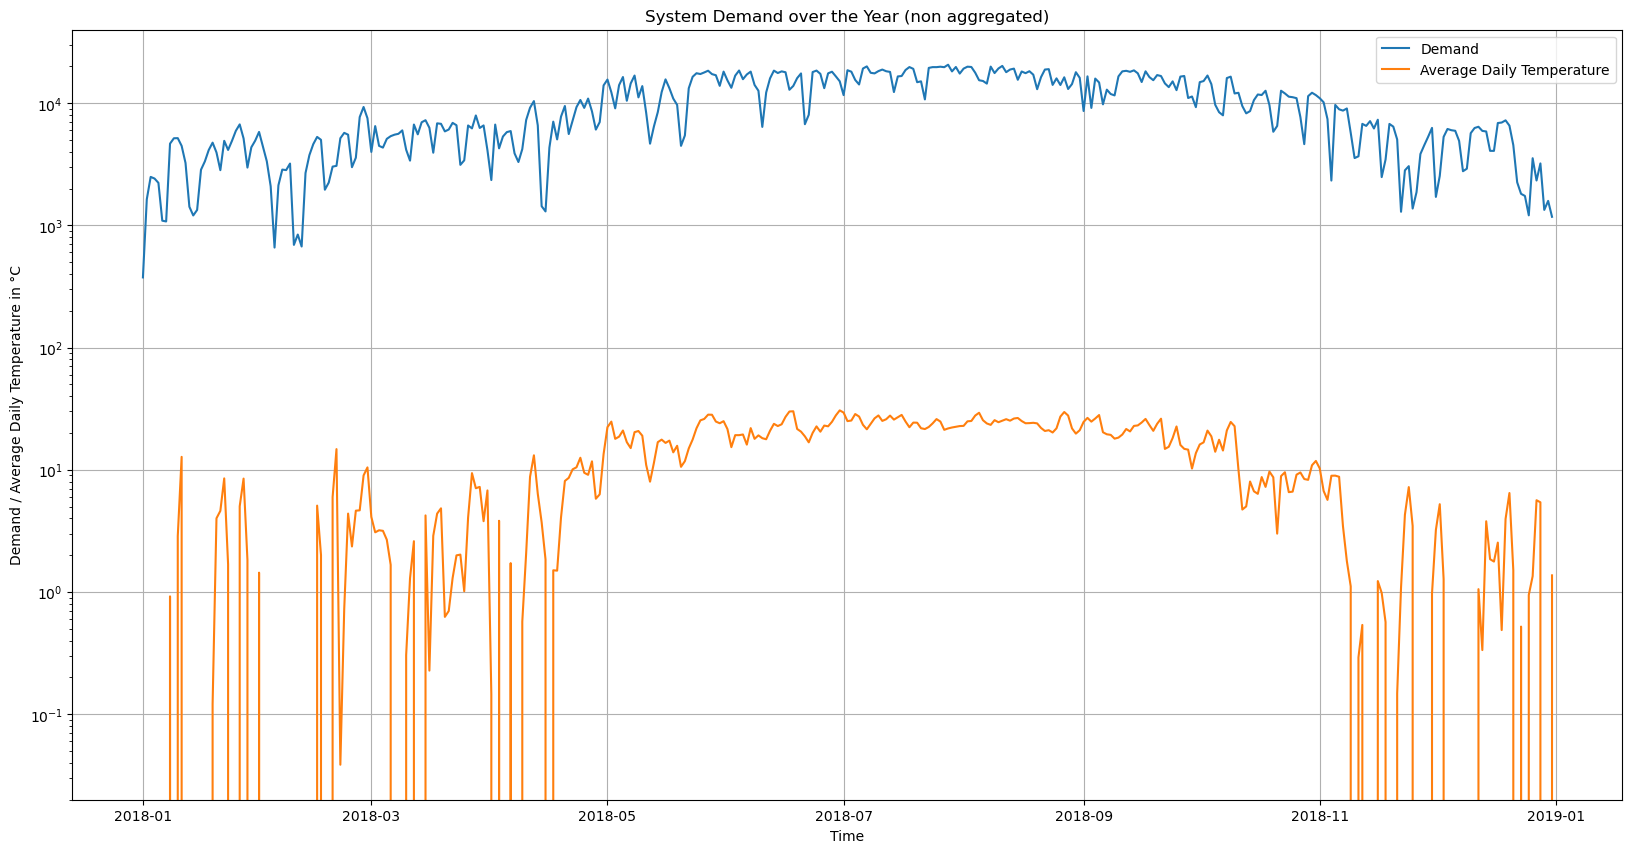

In [459]:
plt.semilogy(df_load_daily['start_time'], df_load_daily['Demand'], df_load_daily['start_time'], df_temp_daily['avg_temp'])
plt.title('System Demand over the Year (non aggregated)')
plt.xlabel('Time')
plt.ylabel('Demand / Average Daily Temperature in °C')
plt.grid(True)
plt.gcf().set_size_inches(20,10)
plt.legend(["Demand", "Average Daily Temperature"])



#plt.show()

#plt.plot(df_temp_daily['start_time'],df_temp_daily['avg_temp'], "r-")
#plt.title('Average Temperature in °C over the Year')
#plt.xlabel('Time')
#plt.ylabel('Average Temperature in °C')
#plt.grid(True)
#plt.show()


<font size = "6">4.3 Feature Selection </font>

Being done with the feature engineering, we now have all of our possible features in a dataframe. Now, the task at hand is, selecting which of those features are actually useful for our predictions later. We aim to filter out the combination of features, which gives us the most precise prediction later one.
For filtering out those features, we utilize two methods. First, a Lasso (also called L1) regression and second a correlation-matrix. The lasso regression will already return us an indicator on how important each of our selected features is, but we also wanted to show that the correlation matrix paints the same picture.

We start by splitting our data into training- and test datasets, to enable our model to cross-validate and therefore increase precision of the tuned hyperparameter lambda. 
We perfrom the split and drop a row that contains NaN values. Due to our extensive cleansing and preparing of the data earlier, no NaN values are in the dataset. However, by creating the prev_Demand column earlier, the first row of our dataset contains a NaN value in this column. Since one row is not too influencial, considering the amount of data we have, we can easily drop this row, without repercussions.

Next, we create a pipeline, which is later utilized for telling the gridsearch, which model and scaler to use. Since the normalize function was depreceated, utilizing the standardscaler has become best practice. Especially when utilizing L1 or L2 regression, scaling the data is essential. Those models put heavy penalty on high magnitudes of features, rendering them almost as non existent. So in order to avoid penalty to unscaled and unnormalized values, we utilize the standardscaler

After that, we start the GridSearchCV, which is testing values for the regularization paramter lambda (in pyhton called alpha) to determine to one with the best performance. Our performance indicator here is the negative mean squared error. 

We fit our model to our training data and retain the best value for lambda: 0.5.
With this hyperparameter successfully tuned, we let the L1 regression give us the importance of our features with the function best_estimator_.named_steps['model'].coef_. Here the rule is, the father the coefficient of a feature is from zero, the more important it is for the prediction.

In [460]:
#splitting data into training and testing data, with a 70% training / 30% testing ratio

df_split = df_load_weather
df_split.set_index('start_time',inplace = True)

train_lasso, test_lasso = train_test_split(df_split, test_size = 0.3, random_state = 42)

# Drop every row that contains nan values in order for regression to work properly
test_lasso.dropna(inplace = True)
train_lasso.dropna(inplace = True)

X_train_lasso = train_lasso.iloc[:,1:]
y_train_lasso = train_lasso.iloc[:,:1]

X_test_lasso = test_lasso.iloc[:,1:]
y_test_lasso = test_lasso.iloc[:,:1]

pipeline_lasso = Pipeline([('scaler',StandardScaler()),
                    ('model', Lasso())
                     ])


search_lasso = GridSearchCV (pipeline_lasso,
                    {'model__alpha':np.arange(0.1, 10, 0.1)},
                      cv = 5, scoring = "neg_mean_squared_error", verbose=3
                      )

# when increasing the lambda range from 10 to 50, the optimal value remains at 0.5

search_lasso.fit(X_train_lasso, y_train_lasso)
print (search_lasso.best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .............model__alpha=0.1;, score=-34388.866 total time=   0.0s
[CV 2/5] END .............model__alpha=0.1;, score=-47053.589 total time=   0.0s
[CV 3/5] END .............model__alpha=0.1;, score=-42533.635 total time=   0.0s
[CV 4/5] END .............model__alpha=0.1;, score=-44312.835 total time=   0.0s
[CV 5/5] END .............model__alpha=0.1;, score=-43099.533 total time=   0.0s
[CV 1/5] END .............model__alpha=0.2;, score=-34387.309 total time=   0.0s
[CV 2/5] END .............model__alpha=0.2;, score=-47055.499 total time=   0.0s
[CV 3/5] END .............model__alpha=0.2;, score=-42518.945 total time=   0.0s
[CV 4/5] END .............model__alpha=0.2;, score=-44320.538 total time=   0.0s
[CV 5/5] END .............model__alpha=0.2;, score=-43098.713 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-34386.657 total time=   0.0s
[CV 2/5] END model__alpha=0.3000000000000000

[CV 1/5] END .............model__alpha=2.1;, score=-34467.598 total time=   0.0s
[CV 2/5] END .............model__alpha=2.1;, score=-47218.217 total time=   0.0s
[CV 3/5] END .............model__alpha=2.1;, score=-42269.943 total time=   0.0s
[CV 4/5] END .............model__alpha=2.1;, score=-44649.075 total time=   0.0s
[CV 5/5] END .............model__alpha=2.1;, score=-43189.344 total time=   0.0s
[CV 1/5] END .............model__alpha=2.2;, score=-34471.737 total time=   0.0s
[CV 2/5] END .............model__alpha=2.2;, score=-47233.502 total time=   0.0s
[CV 3/5] END .............model__alpha=2.2;, score=-42263.169 total time=   0.0s
[CV 4/5] END .............model__alpha=2.2;, score=-44671.062 total time=   0.0s
[CV 5/5] END .............model__alpha=2.2;, score=-43198.347 total time=   0.0s
[CV 1/5] END model__alpha=2.3000000000000003;, score=-34476.226 total time=   0.0s
[CV 2/5] END model__alpha=2.3000000000000003;, score=-47249.241 total time=   0.0s
[CV 3/5] END model__alph

[CV 1/5] END model__alpha=4.3999999999999995;, score=-34652.066 total time=   0.0s
[CV 2/5] END model__alpha=4.3999999999999995;, score=-47623.216 total time=   0.0s
[CV 3/5] END model__alpha=4.3999999999999995;, score=-42194.089 total time=   0.0s
[CV 4/5] END model__alpha=4.3999999999999995;, score=-45248.991 total time=   0.0s
[CV 5/5] END model__alpha=4.3999999999999995;, score=-43446.908 total time=   0.0s
[CV 1/5] END .............model__alpha=4.5;, score=-34664.323 total time=   0.0s
[CV 2/5] END .............model__alpha=4.5;, score=-47643.028 total time=   0.0s
[CV 3/5] END .............model__alpha=4.5;, score=-42195.375 total time=   0.0s
[CV 4/5] END .............model__alpha=4.5;, score=-45279.562 total time=   0.0s
[CV 5/5] END .............model__alpha=4.5;, score=-43461.668 total time=   0.0s
[CV 1/5] END .............model__alpha=4.6;, score=-34676.932 total time=   0.0s
[CV 2/5] END .............model__alpha=4.6;, score=-47663.173 total time=   0.0s
[CV 3/5] END .....

[CV 4/5] END .............model__alpha=6.6;, score=-45686.684 total time=   0.0s
[CV 5/5] END .............model__alpha=6.6;, score=-43710.164 total time=   0.0s
[CV 1/5] END .............model__alpha=6.7;, score=-34862.459 total time=   0.0s
[CV 2/5] END .............model__alpha=6.7;, score=-47905.231 total time=   0.0s
[CV 3/5] END .............model__alpha=6.7;, score=-42266.898 total time=   0.0s
[CV 4/5] END .............model__alpha=6.7;, score=-45707.528 total time=   0.0s
[CV 5/5] END .............model__alpha=6.7;, score=-43719.150 total time=   0.0s
[CV 1/5] END .............model__alpha=6.8;, score=-34870.174 total time=   0.0s
[CV 2/5] END .............model__alpha=6.8;, score=-47915.798 total time=   0.0s
[CV 3/5] END .............model__alpha=6.8;, score=-42270.020 total time=   0.0s
[CV 4/5] END .............model__alpha=6.8;, score=-45727.830 total time=   0.0s
[CV 5/5] END .............model__alpha=6.8;, score=-43728.269 total time=   0.0s
[CV 1/5] END .............mo

[CV 5/5] END .............model__alpha=8.8;, score=-43938.747 total time=   0.0s
[CV 1/5] END .............model__alpha=8.9;, score=-35041.717 total time=   0.0s
[CV 2/5] END .............model__alpha=8.9;, score=-48170.036 total time=   0.0s
[CV 3/5] END .............model__alpha=8.9;, score=-42377.627 total time=   0.0s
[CV 4/5] END .............model__alpha=8.9;, score=-46173.504 total time=   0.0s
[CV 5/5] END .............model__alpha=8.9;, score=-43950.669 total time=   0.0s
[CV 1/5] END .............model__alpha=9.0;, score=-35051.081 total time=   0.0s
[CV 2/5] END .............model__alpha=9.0;, score=-48183.681 total time=   0.0s
[CV 3/5] END .............model__alpha=9.0;, score=-42384.735 total time=   0.0s
[CV 4/5] END .............model__alpha=9.0;, score=-46196.517 total time=   0.0s
[CV 5/5] END .............model__alpha=9.0;, score=-43962.725 total time=   0.0s
[CV 1/5] END .............model__alpha=9.1;, score=-35060.574 total time=   0.0s
[CV 2/5] END .............mo

In [461]:
importance_lasso = np.abs(search_lasso.best_estimator_.named_steps['model'].coef_)
print(importance_lasso)

[  6.506618    35.07705659  22.26616402  36.44979952  86.58721649
   7.41246166  40.01375485  37.2228053    4.73229147  11.09563868
   0.70660412   9.53026174   3.16731386 115.55329392 293.58530104]


From our importance array we can conclude that prev_Demand and in_rush_Hour are very important features for the prediction. Further, non of our features is valued at zero, meaning that non has been "deleted" by the regularization. However, some coefficients are so low in comparison to others that can technically be disregarded.

As mentioned earlier, we now want to visualize the correlation between the features themselfes, as well as their correlation with the hourly demand. This matrix also tells us a similar story about our features, such as a high correlation between demand, in_rush_Hour and avg_temp. However, cos_hour and sin_month have a very "high" negative correlation with the demand, which also means a sort of correlation.

Further, we discovered that the feature season is correlated with the features start_month and avg_temp, meaning it would be redundant to include this feature, rendering it uninteresting. Also, avg_temp and prev_Demand note a high correlation. But, since our regression told us that both features would be of interest for us, we will keep both for now and assume they are not redundant.

(However, we will later check with our performance measures if it actually makes a difference to include both features, or if we can drop one)

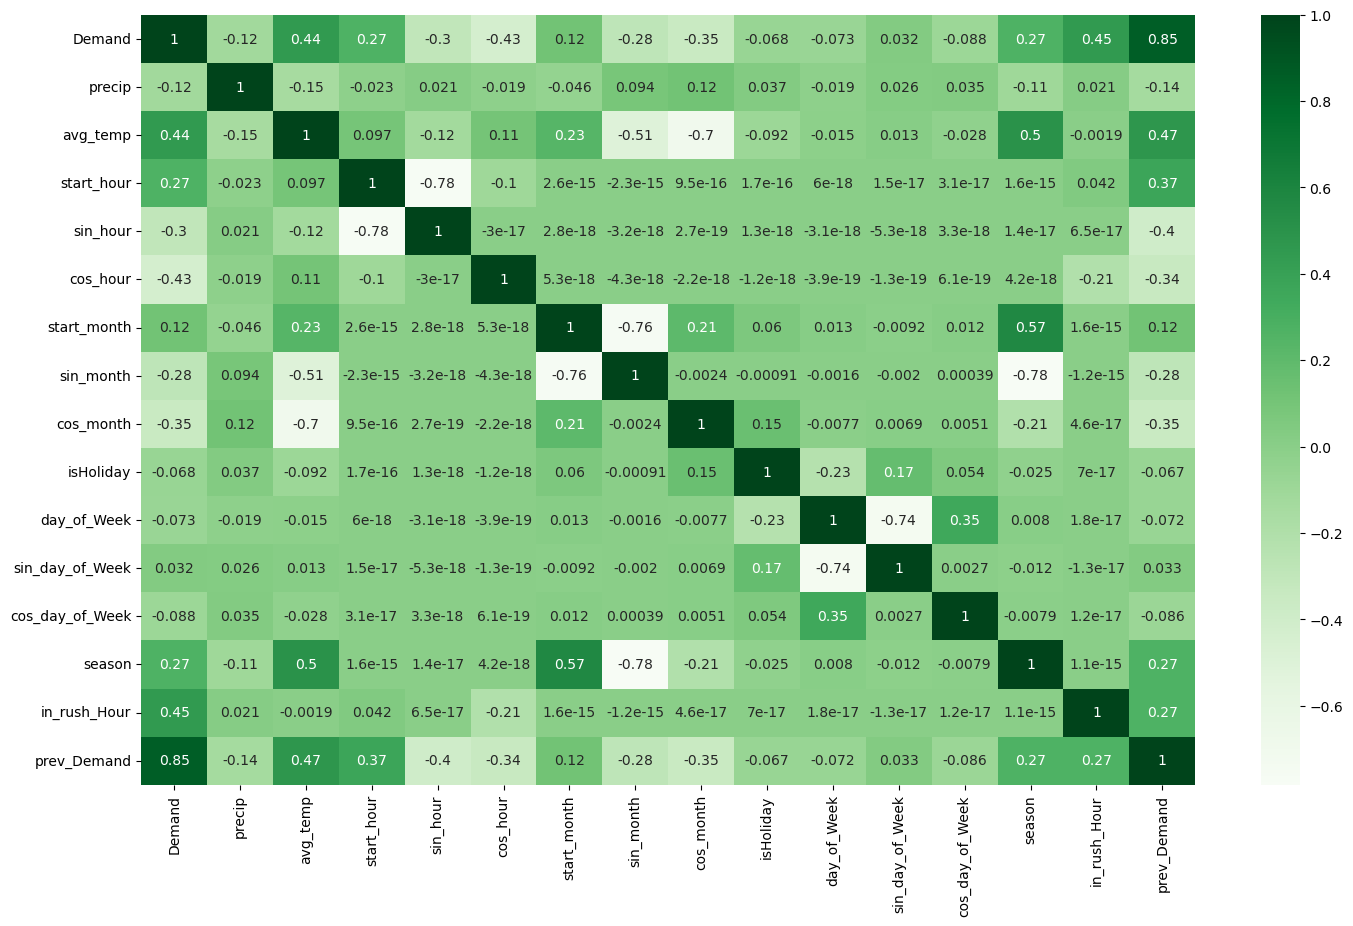

In [31]:
#visualize correlation between features

plt.figure(figsize=(17,10))
sns.heatmap(df_load_weather.corr(), cmap = 'Greens', annot = True)
plt.show()

<font size = "6">4.4 Prediction </font>

Based on the correlation matrix and our L1-Regression earlier, we have an inital combination of features we are going to use for our prediction models. Our chosen features are as follows: cos_hour, sin_month, avg_temp, in_rush_Hour and prev_Demand. With this (first) selection of features, we have completed feature engineering and can now go over to the actual prediction.
We decided to chose following prediction models:

    1. Ridge (L2) - Regression
    2. Decision Tree
    3. K-Nearest Neighbors
    4. Random Forest
    
Firstly, we chose the ridge regression, because we were certain that we needed a polynomial regression. And since we wanted to check the prediction-performance of multiple features, we aimed to minimize the chance of overfitting as far as possible. The ridge-regression seemed matching, as it combined an effective runtime with the strict mitigation of overfitting.

Second, we chose Decision Tree, because... (Diego bitte die anderen hinzufügen)

For our performance metrics, we chose R^2 and MSE.


<font size = "6">4.4.1 Train-Test Split </font>

In the first step, as with the Lasso (L1) regression earlier, we split our dataset into a training and testing part. Training containing 70% of our data and testing 30%. And again, we drop the NaN row, caused by prev_Demand and create our respective X's and y's for training and testing. We do this split to perform cross-validation later on thus accurately access our models performance later on.

In [462]:
features = ['cos_hour','sin_month','avg_temp', 'in_rush_Hour', 'prev_Demand']
#append our label Demand at the end of the array
features.append('Demand')

#features.append(features.pop(features.index('Demand')))
df1 = df_load_weather[features]

# split the data with 70% training data
train, test = train_test_split(df1, test_size = 0.3, random_state = 42)

# Drop every row that contains nan values in order for regression to work properly
test.dropna(inplace = True)
train.dropna(inplace = True)

X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

    

In [480]:
#safety check for NaN values
print(train[train.isna().any(axis=1)])

Empty DataFrame
Columns: [cos_hour, sin_month, avg_temp, in_rush_Hour, prev_Demand, Demand]
Index: []


Like the Lasso(L1) regression before, the Ridge (L2) regression penalizes high magnitudes of features, which is why scaling of our features is also essential here. And just as before, we utilize the standardscaler for this. This tool normalizes/scales of feautres, meaning it transforms in such a ways that their mean value is 0 and their standard deviation is 1. Thus, it helps the model treat the data all the same and not penalize due to different scales of features.

In [468]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

<font size = "6">4.4.2 Hyperparameter Tuning </font>

The next steps towards actual prediction is Hyperparameter Tuning. This means that we need to find the best values for our hyperparameters, the polynomial degree and lambda.

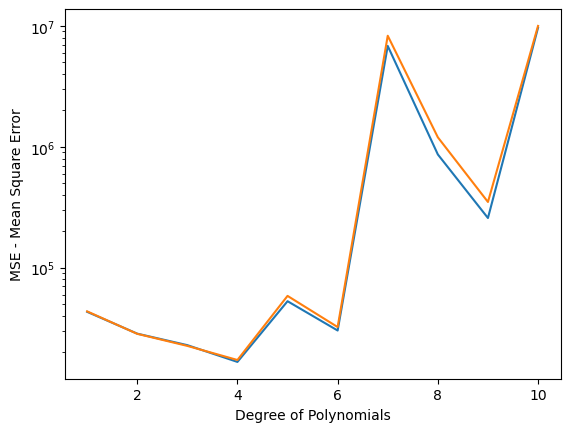

The optimal polynomial degree lies at the degree  4  with an MSE of  17230.028070968023


In [481]:
training_error = []
testing_error = []

for degree_poly in range (1, 11):

    poly = PolynomialFeatures(degree = degree_poly)
    X_train_poly = poly.fit_transform(X_train) 
    X_test_poly = poly.fit_transform(X_test)

    linear_reg = LinearRegression(fit_intercept = False)
    linear_reg.fit(X_train_poly, y_train)
    y_train_pred = linear_reg.predict(X_train_poly)
    y_test_pred = linear_reg.predict(X_test_poly)
    
    training_error.append(((mean_squared_error(y_train_pred, y_train))))
    testing_error.append(((mean_squared_error(y_test_pred, y_test))))
    
    #r_squared_train

plt.semilogy(range(1,11), training_error, range(1,11), testing_error)
plt.xlabel('Degree of Polynomials')
plt.ylabel('MSE - Mean Square Error')
plt.show()

print('The optimal polynomial degree lies at the degree ', testing_error.index(min(testing_error)) + 1,
      ' with an MSE of ', min(testing_error))

Text(0, 0.5, 'Mean Square Error (MSE)')

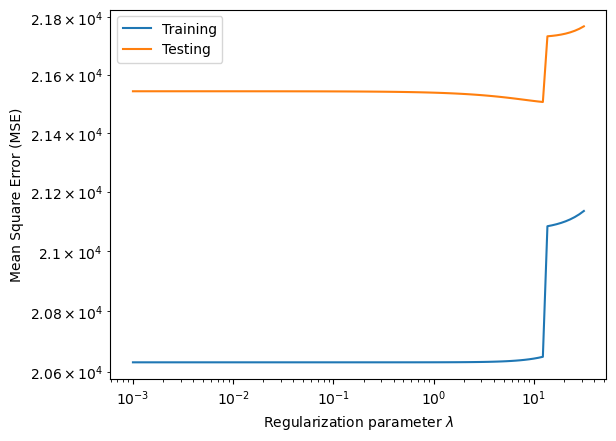

In [218]:
poly_reg = PolynomialFeatures (degree = 4)

x_poly_train_ridge = poly_reg.fit_transform(X_train_scaled)
x_poly_test_ridge = poly_reg.fit_transform(X_test_scaled)

lambd = np.logspace(-3, 1.5, 100)

training_error = []
testing_error = []

for l in lambd:
    
    model_ridge = Ridge(alpha = l, solver = 'lsqr')
    model_ridge.fit(x_poly_train_ridge, y_train)

    y_training_pred = model_ridge.predict(x_poly_train_ridge)
    y_test_pred = model_ridge.predict(x_poly_test_ridge)
    
    training_error.append((mean_squared_error(y_training_pred,y_train)))
    testing_error.append(mean_squared_error(y_test_pred, y_test))
    
plt.loglog(lambd, training_error, lambd, testing_error)
plt.legend(["Training", "Testing"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("Mean Square Error (MSE)")

In [44]:
# For minizing our Testing-error, our regularization parameter should be around 15

In [479]:
# More Precise determination of lambda
data = []
for a in np.arange (10,16,0.1):
    
    alp.append(a)
    optimal_model = Ridge(alpha = a, solver = 'lsqr')
    optimal_model.fit(x_poly_train_ridge, y_train)
    y_test_pred_opt = optimal_model.predict(x_poly_test_ridge)
    data.append([a,mean_squared_error(y_test_pred_opt, y_test),r2_score(y_test_pred_opt, y_test) ])

df_error_r2_score = pd.DataFrame(data, columns = ['Lambda', 'MSE', 'R^2 Score'])


The least MSE ( 21506.422398138857 ) for the Testing Dataset is at the polynomial degree of 4 and the lambda  12.99999999999999 .
The R^2 Score at this Lambda is:  0.9011013998086682


In [482]:
row = df_error_r2_score.loc[df_error_r2_score['MSE'] == df_error_r2_score['MSE'].min()]
print('The least MSE (',  df_error_r2_score['MSE'].min(),
      ') for the Testing Dataset is at the polynomial degree of 4 and the lambda '
      , row.iloc[0]['Lambda'], '.\nThe R^2 Score at this Lambda is: ', row.iloc[0]['R^2 Score'])

The least MSE ( 21506.422398138857 ) for the Testing Dataset is at the polynomial degree of 4 and the lambda  12.99999999999999 .
The R^2 Score at this Lambda is:  0.9011013998086682


## Decision Tree

In [222]:
demand = y_train.values
average_temperature = X_train['avg_temp'].values

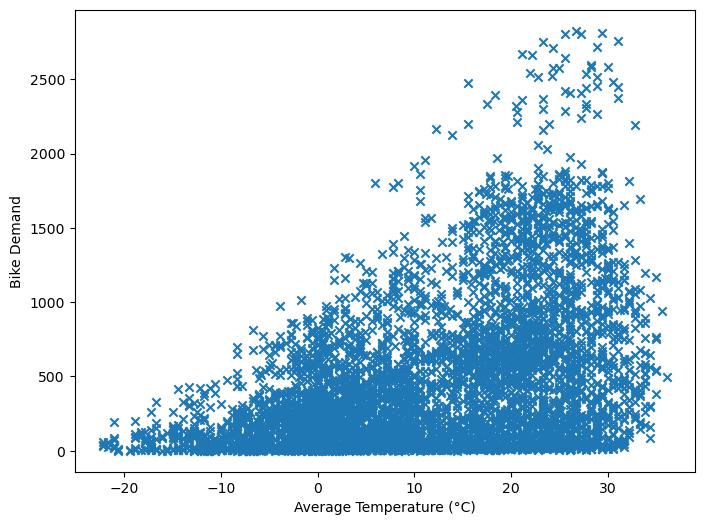

In [233]:
plt.figure(figsize = (8,6))
plt.scatter(average_temperature, demand, marker="x")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Bike Demand")
plt.show()

In [234]:
def plot_tree_regression_line(tree_depth, dependent_variable, regressor):

    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="squared_error") # Other options: "friedman_mse", "mae"
    Tree_reg.fit(regressor.reshape((-1,1)), dependent_variable)
    Y_pred = Tree_reg.predict(regressor.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(regressor, dependent_variable, marker="x")
    plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(dependent_variable, Y_pred))
    

number of nodes:  269
number of leafs:  135
R^2:  0.23670963090766572


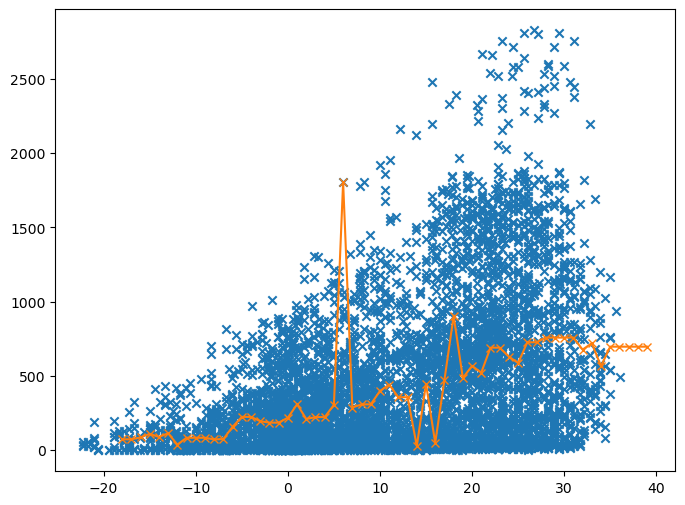

In [235]:
plot_tree_regression_line(8, demand, average_temperature)

In [236]:
previous_demand = X_train['prev_Demand'].values

number of nodes:  397
number of leafs:  199
R^2:  0.7776233979394647


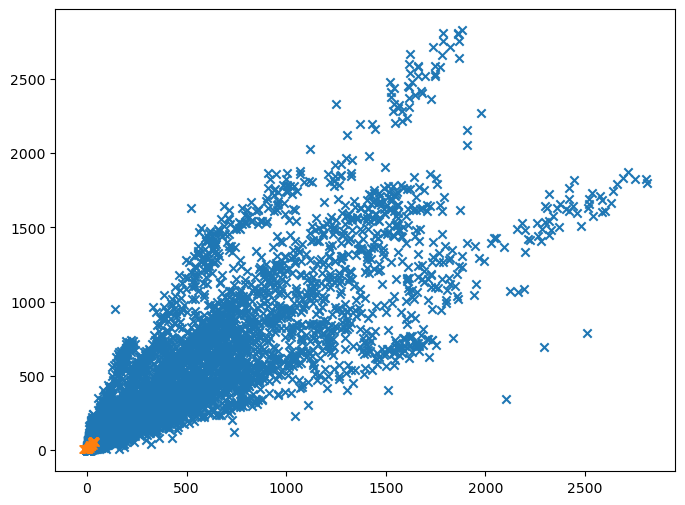

In [237]:
plot_tree_regression_line(8, demand, previous_demand)

In [238]:
def plot_regression_tree_sklearn(tree_depth, dependent_variable, regressor):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(regressor.reshape((-1,1)), dependent_variable) 
    
    dot_data = export_graphviz(model,
                              feature_names=["High_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph


In [239]:
plot_regression_tree_sklearn(3, demand, average_temperature)

NameError: name 'graphviz' is not defined

#### Fit on whole dataset

In [240]:
tree_depth = 8
# Fit regression model (to full data)
Tree_reg = DecisionTreeRegressor(
    max_depth=tree_depth,criterion="squared_error"
)
Tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8)

#### Performance on training data

In [241]:
y_pred_train = Tree_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  10214.11607161017
R squared:  0.9541928225138494


#### NaN in test set

In [45]:
X.isna().any()

precip             False
avg_temp           False
start_hour         False
sin_hour           False
cos_hour           False
start_month        False
sin_month          False
cos_month          False
isHoliday          False
day_of_Week        False
sin_day_of_Week    False
cos_day_of_Week    False
season             False
in_rush_Hour       False
prev_Demand         True
dtype: bool

In [46]:
X_clean = X.iloc[1:]
y_clean = y.iloc[1:]
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size = 0.3, random_state = 42)

#### Performance on test data

In [47]:
y_pred_test = Tree_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  8172.43038105756
R squared:  0.9638284235210453


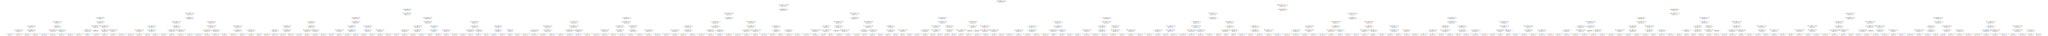

In [48]:
dot_data = export_graphviz(
    Tree_reg,
    feature_names=X.columns
)
graph = graphviz.Source(dot_data) 
graph

#### Hyperparameter tuning

In [56]:
def fit_decision_tree(tree_depth):
    Tree_reg = DecisionTreeRegressor(
        max_depth=tree_depth,criterion="squared_error"
    )
    Tree_reg.fit(X_train, y_train)
    return Tree_reg

In [75]:
def evaluate_decision_tree_train(tree_depth):
    reg = fit_decision_tree(tree_depth)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_decision_tree_test(tree_depth):
    reg = fit_decision_tree(tree_depth)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

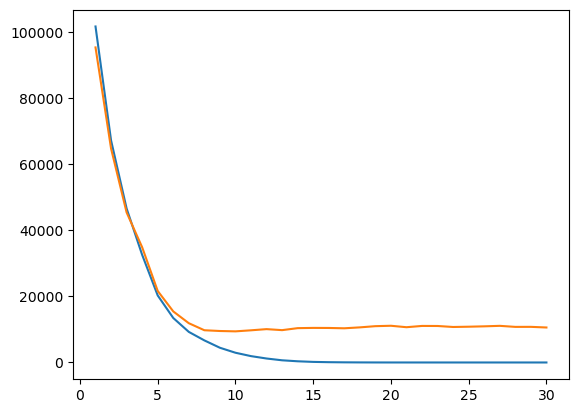

In [76]:
x = np.linspace(1, 30, 30, dtype = int)
plt.plot(x, list(map(evaluate_decision_tree_train, x)))
plt.plot(x, list(map(evaluate_decision_tree_test, x)))
plt.show()

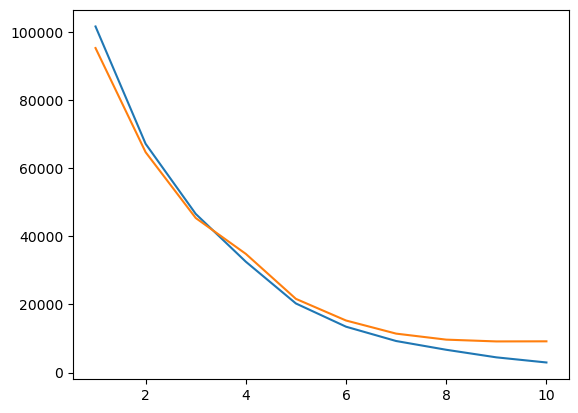

In [77]:
x = np.linspace(1, 10, 10, dtype = int)
plt.plot(x, list(map(evaluate_decision_tree_train, x)))
plt.plot(x, list(map(evaluate_decision_tree_test, x)))
plt.show()

## Random Forest

In [49]:
RandomForest_reg = RandomForestRegressor(max_depth=10, random_state=0)
RandomForest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

#### Performance on training data

In [50]:
y_pred_train = RandomForest_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  2191.5827496236298
R squared:  0.9905237206076484


#### Performance on test data

In [51]:
y_pred_test = RandomForest_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  5953.950223582947
R squared:  0.9736475251764273


#### Hyperparameter tuning

In [80]:
def fit_forest(max_depth):
    reg = RandomForestRegressor(
        max_depth=max_depth, 
        random_state=0
    )
    reg.fit(X_train, y_train)
    return reg

In [81]:
def evaluate_forest_train(max_depth):
    reg = fit_forest(max_depth)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_forest_test(max_depth):
    reg = fit_forest(max_depth)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

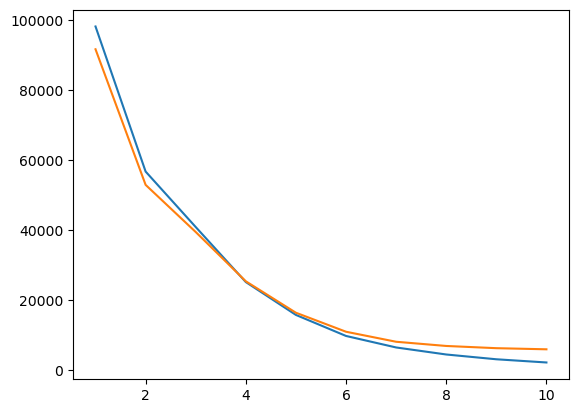

In [84]:
x = np.linspace(1, 10, 10, dtype = int)
plt.plot(x, list(map(evaluate_forest_train, x)))
plt.plot(x, list(map(evaluate_forest_test, x)))
plt.show()

## K-Nearest Neighbors

In [52]:
KNeighbor_reg = KNeighborsClassifier(n_neighbors=2)
KNeighbor_reg.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

#### Performance on training data

In [94]:
y_pred_train = KNeighbor_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  32853.30712771163
R squared:  0.8579441650750365


#### Performance on test data

In [93]:
y_pred_test = KNeighbor_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  66031.75152207002
R squared:  0.7077402389678348


#### Hyperparameter tuning

In [86]:
def fit_neighbors(n_neighbors):
    reg = KNeighborsClassifier(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    return reg

In [87]:
def evaluate_neighbors_train(n_neighbors):
    reg = fit_neighbors(n_neighbors)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_neighbors_test(n_neighbors):
    reg = fit_neighbors(n_neighbors)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

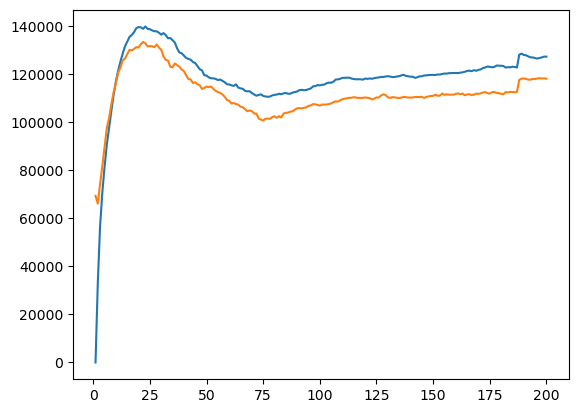

In [97]:
x = np.linspace(1, 200, 200, dtype = int)
plt.plot(x, list(map(evaluate_neighbors_train, x)))
plt.plot(x, list(map(evaluate_neighbors_test, x)))
plt.show()